In [1]:
from rdkit import Chem
from PIL import Image
from PIL import ImageDraw
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline



# Colors from https://sciencenotes.org/molecule-atom-colors-cpk-colors/
colors = {
    'H'  : "#FFFFFF",
    'C'  : "#909090",
    'O'  : "#FF0D0D",
    'N'  : "#3050F8",
    'S'  : "#FFFF30",
    'P'  : "#FF8000",
    'B'  : "#FFB5B5",
    'F'  : "#90E050",
    'K'  : "#8F40D4",
    'I'  : "#940094",
    'Na' : "#AB5CF2",
    'Cl' : "#1FF01F",
    'Br' : "#A62929",
    '_'  : "#000000", # Color for bonds, connections and brackets
         }

colors = {k : np.array([int(v[1:3],16) / 255.,
                        int(v[3:5],16) / 255.,
                        int(v[5:7],16) / 255.])
             for k,v in colors.items()
         }




look_ahead = {
    'C' : 'l',
    'N' : 'a',
    'B' : 'r'
}




skip = ["@", "[", "]"]


def colorSMILES(smi):
    max_nested = 3
    max_connections = 5
    width = 12 
    height = 18
    off = width // 2
    
    upper = max_nested
    mid = upper + height // 2 
    lower = upper + height
    max_len = 100 # Number of atoms and "non-singel" bonds 
    lvl = 0
    active_con = [-1] * max_connections
    im_arr = np.ones((height+max_connections+max_nested,
                      width * max_len, 3))
    
    
    
    parsed = False
    pos = 0
    
    startP = [False] * max_nested
    
    for i,c in enumerate(smi):
        
        
        if c in skip:
            continue
        
        if parsed:
            parsed = False
            continue
        
        full = c.isupper()
        
        if c == "(":
            startP[lvl] = True
            lvl += 1
            continue
        elif c == ")":
            lvl -= 1
            continue

            
        if c.isnumeric():
            n = int(c)-1
            ended_con = active_con[n]
            if active_con[n] < 0:
                for k in range(max_nested):
                    if not k in active_con:
                        break
                active_con[n] = k
                im_arr[lower+k:lower+1+k,pos-width:pos] = colors["_"]
            else:
                active_con[n] = -1
            continue
            
        if c in look_ahead and i+1 < len(smi) and (
                smi[i+1] and look_ahead[c] == smi[i+1]):
            c += smi[i+1]
            parsed = True
        else:
            c = c.upper()

        if c in colors:
            col  = colors[c]
            u = upper if full else mid
            im_arr[u:lower,pos:pos+width] = col            
            
        else:
            col = colors["_"]
            
            if c == "-" or c == "#":
                im_arr[mid,pos:pos+width] = col  
            if c == "=" or c == "#":
                im_arr[[mid + x for x in [-3,3]],
                       pos:pos+width] = col
                
        
        # Parentheses
        for i in range(lvl):            
            ps = pos + (off if startP[i] else 0)
            pe = pos + width
            im_arr[upper-i-1:upper-i,ps:pe] = colors["_"]
            startP[i] = False

            
        # Connections
        for i in range(len(active_con)):            
            if active_con[i] >= 0:
                k = active_con[i]
                im_arr[lower+k:lower+1+k,pos:pos+width] = colors["_"]
                
        
        
        
        pos += width

    startP = []
    stopP = []

    return im_arr




def SMILESToImage(smi, background=None):
    
    char_width = 6
    height = 17
    num_chars = 100
    width = char_width * num_chars
    
    if background is None:
        img = Image.new("RGB", (width, height), (255, 255, 255))
    else:
        img = background
    
    
    draw = ImageDraw.Draw(img)
    w, h = draw.textsize(smi)
    
    p = 0
    saved = ""
    
    for i,c in enumerate(smi):
        
        if c in skip:
            continue
        
        if c.isnumeric() or c in ["(", ")"]:
            continue
            
        if c in look_ahead and i+1 < len(smi) and (
                smi[i+1] and look_ahead[c] == smi[i+1]):
            saved += c
            continue

        
        c = saved + c
        saved = ""
        o = 1 if len(c) == 1 else 0
        
        draw.text((p + o,h/2+5), c, fill="black")
        p += 2*char_width
            
    return img






def generateImageSMILE(smi):
    
    char_width = 6
    height = 17
    num_chars = 100
    width = char_width * num_chars
    
    img = Image.new("RGB", (width, height), (255, 255, 255))
    
    draw = ImageDraw.Draw(img)
    w, h = draw.textsize(smi)

    draw.text((0,h/2), smi, fill="black")

    return img
    
    
    
    

def generateImageSMILEColor(smi, withChars=True):
    
    bg = Image.fromarray((colorSMILES(smi) * 255).astype("uint8"))    
    if withChars:
        return SMILESToImage(smi, bg)
    else:
        return bg
    


    
    
#smi = "[NH]Cc1ccc(cc1C#Cc2cnc3n2nccc3)C(=O)Nc4ccc(c(c4)C(F)(F)F)"
smi = "COc1ccc(N2CC(=O)N(C(=O)COc3ccc(OCC(=O)N4C(=O)CN(c5ccc(OC)cc5)C4=S)cc3)C2=S)cc1"
smi = 'c1ccc(N2CC(=O)N(C(=O)COc3ccc(OCC(=O)N4C(=O)CN(c5ccccc5)C4)cc3)C2)cc1'
smi = 'c1ccc(N2CC(=O)N(C(=O)COc3ccc(OCC(=O)N4C(=O)CN(c5ccccc5)C4)cc3)C2)cc1'




In [15]:



smi = "COc1ccc(N2CC(=O)N(C(=O)COc3ccc(OCC(=O)N4C(=O)CN(c5ccc(OC)cc5)C4=S)cc3)C2=S)cc1"
mol = Chem.MolFromSmiles(smi)
smi = Chem.MolToSmiles(mol)
generateImageSMILEColor(smi, False)



In [ ]:
generateImageSMILE(smi)

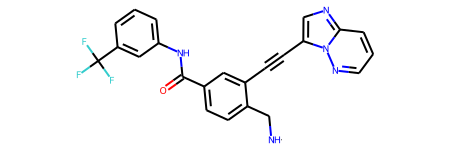

In [ ]:
Chem.MolFromSmiles(smi)

In [ ]:

    print("__________Accuracy and AUC__________")
    print("Train Accuracy: ")
    print(model_train_accuarcy)
    print("Train Accuracy average: " + str(statistics.mean(model_train_accuarcy)))
    print("Train Accuracy standard deviation: " + str(statistics.stdev(model_train_accuarcy)))

    print("Validation Accuracy: ")
    print(model_val_accuarcy)
    print("Validation Accuracy average: " + str(statistics.mean(model_val_accuarcy)))
    print("Validation Accuracy standard deviation: " + str(statistics.stdev(model_val_accuarcy)))

    print("Test Accuracy: ")
    print(model_test_accuarcy)
    print("Test Accuracy average: " + str(statistics.mean(model_test_accuarcy)))
    print("Test Accuracy standard deviation: " + str(statistics.stdev(model_test_accuarcy)))
    print()

    print("Train AUC: ")
    print(model_train_AUC)
    print("Train AUC average: " + str(statistics.mean(model_train_AUC)))
    print("Train AUC standard deviation: " + str(statistics.stdev(model_train_AUC)))

    print("Valid AUC: ")
    print(model_val_AUC)
    print("Validation AUC average: " + str(statistics.mean(model_val_AUC)))
    print("Validation AUC standard deviation: " + str(statistics.stdev(model_val_AUC)))

    print("Test AUC: ")
    print(model_test_AUC)
    print("Test AUC average: " + str(statistics.mean(model_test_AUC)))
    print("Test AUC standard deviation: " + str(statistics.stdev(model_test_AUC)))
    print()
